# 13. Aprendizaje por Refuerzo - Trading Bot

Vamos a entrenar un agente para que aprenda a operar en el mercado de valores. Para ello, vamos a crear un entorno de simulación de trading y un algoritmo de aprendizaje por refuerzo.

El entorno de simulación de trading es una implementación de la clase `StockTradingEnv` de la librería `gym` que simula un mercado de valores. El agente puede realizar las siguientes acciones en cada paso de tiempo:
- **0**: No hacer nada
- **1**: Comprar
- **2**: Vender


## Preparación del entorno

Usaremos las librerías:
- `numpy` para operaciones matemáticas
- `gym` para crear el entorno de simulación de trading
- `stable_baselines3` para entrenar el agente con el algoritmo PPO

In [1]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# Load the dataset
df = pd.read_csv('aapl.txt')
df.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'OpenInt'], axis=1, inplace=True)
df = df.iloc[5000:]
df = df.reset_index(drop=True)
df

df_norm = (df - df.min()) / (df.max() - df.min())
df_norm

,Close
0,0.000464
1,0.000370
2,0.000333
3,0.000000
4,0.000029
...,...
3359,0.988604
3360,0.991770
3361,1.000000
3362,0.997928


Vamos a trabajar con el precio de cierre diario de Apple para los últimos 9 años.

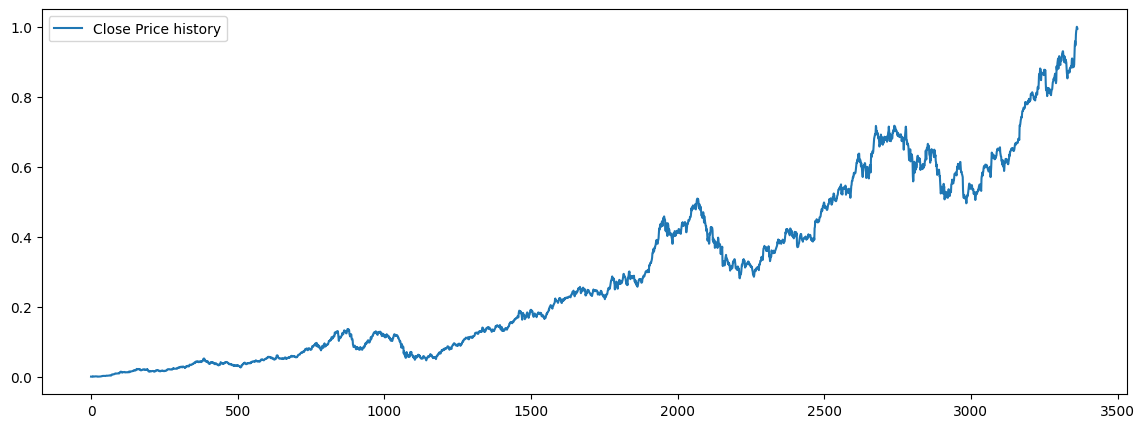

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(df_norm['Close'], label='Close Price history')
plt.legend()
plt.show()


Definimos los parámetros que puedieramos encontrarnos en un entorno real:
- `INITIAL_ACCOUNT_BALANCE`: Saldo inicial de la cuenta
- `TRANSACTION_FEE_PERCENT`: Comisión por transacción
- `WINDOW_SIZE`: Tamaño de la ventana de tiempo



In [3]:
# Parameters
INITIAL_ACCOUNT_BALANCE = 10000
TRANSACTION_FEE_PERCENT = 0.001
WINDOW_SIZE = 20  # Number of past observations to include in the state

Stable Baselines nos proporciona un método de definir sola una parte del problema, encargándose la librería de la parte de definir el modelo y entrenarlo.

In [4]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.window_size = WINDOW_SIZE
        self.reward_range = (0, INITIAL_ACCOUNT_BALANCE)
        
        # Define action and observation space
        # Actions: 0 - hold, 1 - buy, 2 - sell
        self.action_space = spaces.Discrete(3)
        
        # Observation space: current and past 'Close' prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.window_size,), dtype=np.float16)
        
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.current_step = 0

    def _next_observation(self):
        # Use the past WINDOW_SIZE points as the observation space
        obs = self.df['Close'][self.current_step:self.current_step + self.window_size].to_numpy()
        if len(obs) < self.window_size:
            obs = np.pad(obs, (self.window_size - len(obs), 0), 'constant', constant_values=0)
        return obs

    def step(self, action):
        self.current_step += 1
        
        if self.current_step > len(self.df) - self.window_size:
            self.done = True
        else:
            self.done = False

        current_price = self.df['Close'].iloc[self.current_step]
        reward = 0

        
        if action == 1:  # Buy
            # Assuming we buy one share per action for simplicity
            self.balance -= current_price * (1 + TRANSACTION_FEE_PERCENT)
            self.shares_held += 1
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.balance += current_price * (1 - TRANSACTION_FEE_PERCENT)
                self.shares_held -= 1
                reward = (current_price - self.df['Close'].iloc[self.current_step - 1]) * self.shares_held
            else:
                reward = -current_price * TRANSACTION_FEE_PERCENT  # Penalty for attempting to sell with no shares held

        obs = self._next_observation()

        return obs, reward, self.done, {}

    def reset(self):
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.current_step = 0
        return self._next_observation()

    def render(self, mode='human', close=False):
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Shares held: {self.shares_held}')
        print(f'Current Value: {self.shares_held * self.df["Close"].iloc[self.current_step] if self.shares_held > 0 else 0}')
        print(f'Total Value: {self.balance + (self.shares_held * self.df["Close"].iloc[self.current_step] if self.shares_held > 0 else 0)}\n')


In [6]:
# Create and wrap the environment
env = StockTradingEnv(df)
env = DummyVecEnv([lambda: env])

# Instantiate the agent with the policy and environment
model = A2C('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=20000)

# Save the model
model.save("a2c_stock_trading_model")

# Load the model (for demonstration purposes, normally you'd do this to resume training or for evaluation)
model = A2C.load("a2c_stock_trading_model", env=env)

c:\Users\icira\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 1073     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.965   |
|    explained_variance | 0.134    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0209  |
|    value_loss         | 0.00116  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1061     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.773   |
|    explained_variance | 0.124    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -0.972   |
|    value_loss      

Para que el agente pueda aprender a operar correctamente necesita ser entrenado durante mucho tiempo, aquí solo hemos ejecutado unos pocas iteraciones para que el código se ejecute rápidamente.

Preparamos funciones para representar los resultados y para entrenar el agente.

In [7]:
import matplotlib.pyplot as plt

def plot_trading_results(df, actions):
    """
    Plot the stock prices and overlay buy and sell signals.

    Parameters:
    - df: Pandas DataFrame with the stock 'Close' prices.
    - actions: List of actions taken by the agent. Same length as df. 1 for buy, 2 for sell, 0 for hold.
    """
    # Create a figure and a set of subplots
    plt.figure(figsize=(14, 7))
    
    # Plot the closing prices
    plt.plot(df['Close'], label='Close Price', color='skyblue', lw=2)
    
    # Plot buy signals
    buy_signals = [i for i in range(len(actions)) if actions[i] == 1]
    plt.scatter(df.iloc[buy_signals].index, df['Close'][buy_signals], label='Buy', marker='^', color='green', alpha=1)
    
    # Plot sell signals
    sell_signals = [i for i in range(len(actions)) if actions[i] == 2]
    plt.scatter(df.iloc[sell_signals].index, df['Close'][sell_signals], label='Sell', marker='v', color='red', alpha=1)
    
    # Title & labels
    plt.title('Stock Price and Trading Signals')
    plt.xlabel('Days')
    plt.ylabel('Price')
    
    # Show legend
    plt.legend(loc='best')
    
    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

In [8]:
def fetch_model_actions(model, env):
    """
    Simulate the environment with the given model and record all actions taken.

    Parameters:
    - model: The trained model.
    - env: The trading environment.

    Returns:
    - actions: List of actions taken by the model.
    """
    # Reset the environment and get the initial state
    obs = env.reset()
    done = False
    actions = []

    while not done:
        # Predict the action with the model
        action, _states = model.predict(obs, deterministic=True)
        actions.append(action[0])

        # Step the environment
        obs, rewards, done, info = env.step(action)

    return actions



In [9]:
# Assuming 'model' is your trained model and 'env' is your trading environment
actions = fetch_model_actions(model, env)


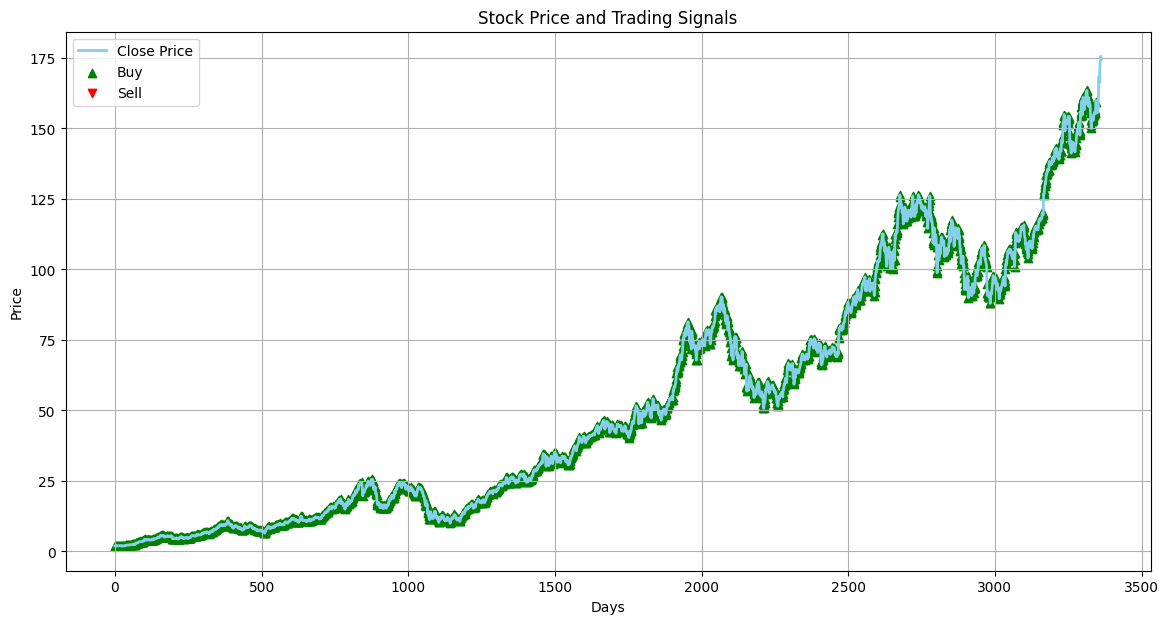

Number of buy signals: 3345
Number of sell signals: 0


In [10]:
# plot the data for close
plot_trading_results(df, actions)

# count number of buy and sell signals
buy_signals = [i for i in range(len(actions)) if actions[i] == 1]
sell_signals = [i for i in range(len(actions)) if actions[i] == 2]
print(f'Number of buy signals: {len(buy_signals)}')
print(f'Number of sell signals: {len(sell_signals)}')

